# 로지스틱 회귀 개요

* 베르누이 분포 : 긍정 확률 P와 부정 확률 1-P를 갖는 랜덤 변수의 확률 분호 (자연계의 일반적인 정규분포와 대칭이 되는 구조의 분포)
* 베르누이 분포를 따르는 반응 변수의 확률 범위는 [0, 1]
* 선형 회귀는 특징 값의 일정한 변화로 반응 변수에도 일정한 변화가 일어난다는 가정을 하므로, 반응 변수가 확률을 나타낼 경우 가정이 유효하지 않음
* 일반화 선형 모델은 연결 함수를 사용해 특징의 선형 조합을 반응 변수와 연결 짓는 방법을 통해 선형 회귀의 가정을 없앰
* 특징의 선형 조합을 정규 분포에 따르지 않는 반응 변수와 연계하려면 연결함수가 필요

# 로지스틱 회귀 특징

* `로지스틱 회귀의 반응 변수의 값 = 긍정(양성) 클래스의 확률`
* `반응 변수의 값 >= 임계치(0.5) --> 긍정(양성) 클래스를 예측`
* `반응 변수의 값 < 임게치 --> 부정(음성) 클래스를 예측`
* `반응 변수는 "로지스틱 함수 == 시그모이드 함수"를 사용해 특징의 선형 조합 함수로 모델링 됨` <br>
(test instance를 사용해서 값이 0~1 사이의 값이 나오게 계산해 주는 것이 로지스틱 함수)
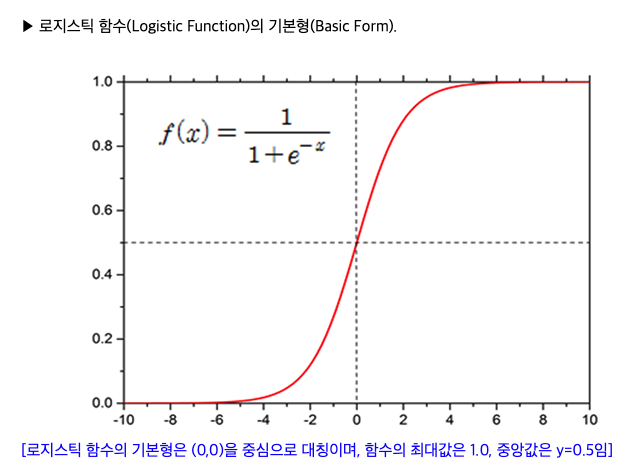
* $e$는 오일러 상수, $x$는 설명 변수의 조합($\beta_0 + \beta_1x_1 + \beta_2x_2 + ...$)
* 로지스틱 함수 == 시그모이드 함수(Sigmoid)
  
* 로짓 함수는 로지스틱 함수의 역함수 : $f(x)$를 다시 특징의 조합으로 돌림
* --> odds rate(==승산비)
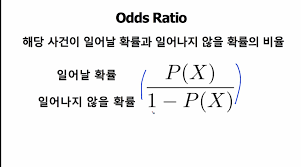 
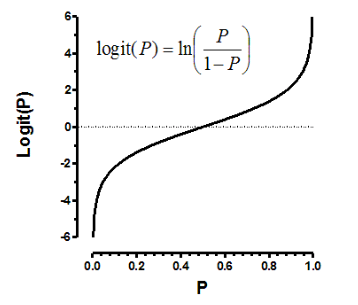

# 시그모이드 함수 == 로지스틱 함수 구현

In [25]:
import numpy as np

def sigmoid(z) :
    return 1.0 / (1 + np.exp(-z))

Text(0, 0.5, 'y(z)')

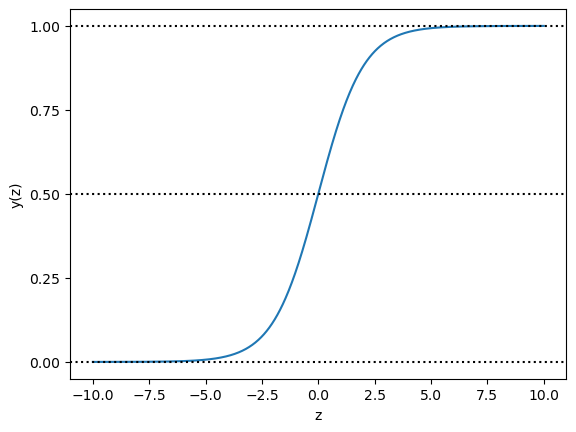

In [26]:
import matplotlib.pyplot as plt

z = np.linspace(-10, 10, 1000)
y = sigmoid(z)
plt.plot(z, y)
plt.axhline(y=0, ls=':', c='k')
plt.axhline(y=0.5, ls=':', c='k')
plt.axhline(y=1, ls=':', c='k')
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('z')
plt.ylabel('y(z)')

# y(z) >= 0.5 --> 양성 클래스
# y(z) < 0.5 --> 음성 클래스

# 그래서 로지스틱 회귀는 이진 분류 중 하나이다.
# 스팸메일(양성:1) vs 일반메일(음성:0)
# 흡연(양성:1) vs 비흡연(음성:0)

# 로지스틱 회귀 모델 적용 실습

## 데이터 준비

In [27]:
import pandas as pd

train_df = pd.read_csv('train', nrows=100000)  
unused_columns, label_column = ['id', 'hour', 'device_id', 'device_ip'], 'click' # 사용하지 않을 Columns, label Column 지정

# 훈련용 데이터 생성
train_df = train_df.drop(unused_columns, axis=1)
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values()) # 특징행렬을 만들기 전에, df->dictionary 형태로 바꾸어 그 안의 values만 추출
X_dict_train[0] # 
y_train = train_df[label_column] # 대상벡터

In [28]:
# 평가용 데이터 생성
test_df = pd.read_csv('train', header=0, skiprows=(1, 100000), nrows=100000) # 1 ~ 100,000행은 앞서 읽어왔기 때문에 그 부분을 skip.
test_df = test_df.drop(unused_columns, axis=1)
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

## One-Hot Encoding 벡터 변환

자연어를 컴퓨터가 처리하도록 하기 위해서 숫자로 바꾸는 방법을 알아야 한다. <br>
문자를 기계가 이해할 수 있는 숫자로 바꾼 결과 또는 그 과정을 임베딩(Embedding)이라고 한다. <br>
가장 간단한 형태의 임베딩은 문장에 어떤 단어가 많이 쓰였는지를 파악하여 글쓴이의 의도를 알 수 있다. <br>
원-핫 인코딩(One-Hot Encoding)은 여러 기법 중 단어를 표현하는 가장 기본적인 표현 방법이다.<br>

<u>scikit-learn의 트리 기반의 모델들의 중요한 특징은 입력 변수로 사용하는 특징을 모두 수치로 쓴다는 것.</u>

원 핫 인코딩 벡터 변환 방법이 다양한데 dictionary로 변환한 이유는 일괄 적용하기 위함.

In [29]:
from sklearn.feature_extraction import DictVectorizer

# vectorizing할 때, 이진 변환하니까 0이 무수히 많이 생긴다.
# 0이 무수히 많아지면 메모리 낭비가 심해지기 때문에, 희소 행렬 형태로 작업해야 메모리 문제를 해결할 수 있다.
vectorizer = DictVectorizer(sparse=True) 

# 훈련용 데이터에 대해 One-Hot Encoding 벡터 변환
X_train = vectorizer.fit_transform(X_dict_train)
X_train.shape  # 19차원에서 4952차원으로 늘어남. (범주형 데이터를 이진 변환했기 때문)

(100000, 4952)

In [30]:
X_train.toarray()[:5] # 희소행렬이 아닌 정상적인 행렬 형태로 다시 변환.

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

In [31]:
# 평가용 데이터에 대해서도 One-Hot Encoding 벡터 변환
X_test = vectorizer.fit_transform(X_dict_test) 
X_train.toarray()[:5]

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

## GridSearchCV를 이용한 로지스틱 회귀 모델 학습
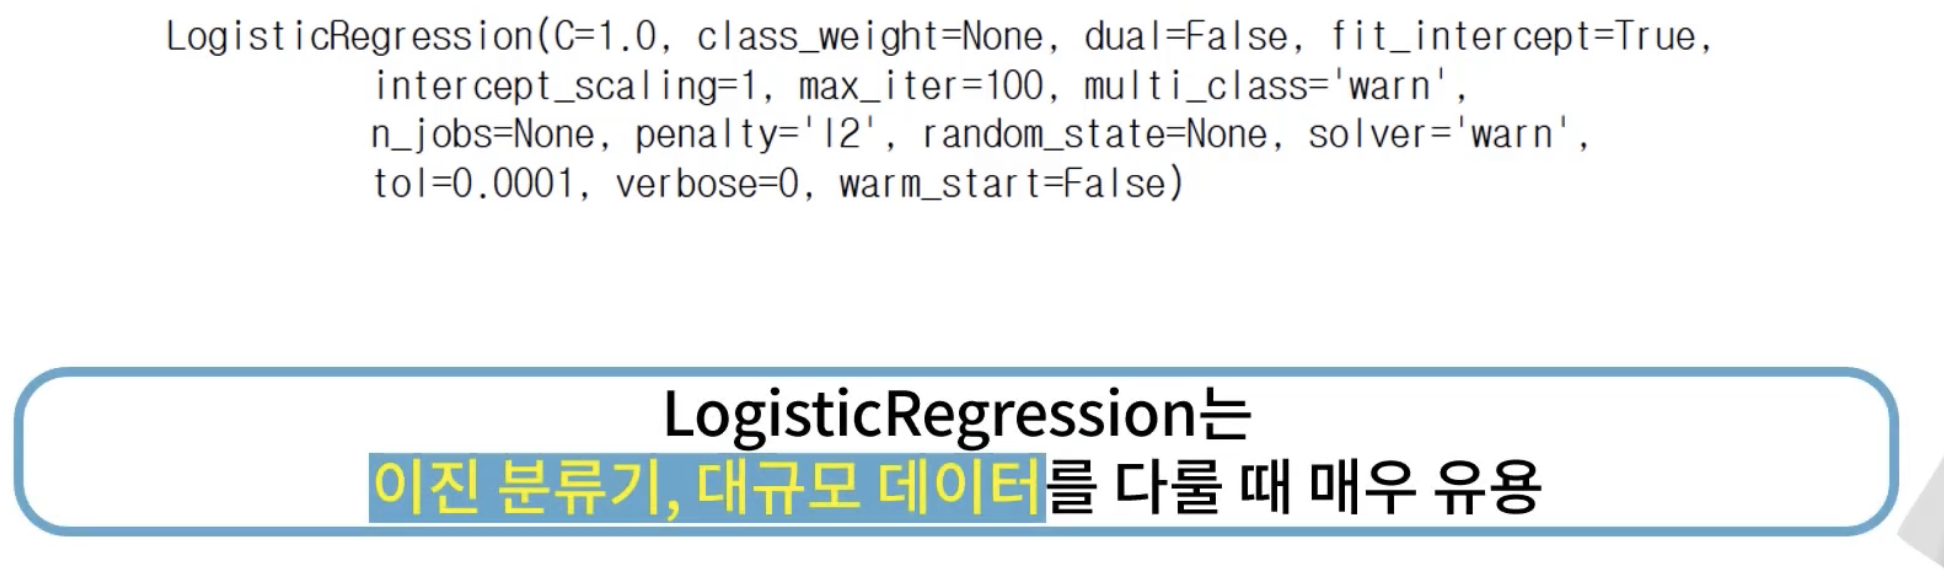

* penalty='l2'  -> L2규제는 계수값이 0에 가까워짐. Ridge 회귀
* penalty='l1'  -> L1규제는 계수값이 0이 됨. Lasso 회귀
* C : penalty의 강도를 조절하는 파라미터 (C의 값이 클수록 규제가 느슨, 0에 가까워지면 규제가 강해짐)

In [32]:
from sklearn.linear_model._logistic import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

/Users/ihyeongseob/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {"C" : [0.001, 0.01, 0.1, 1, 1.0], "penalty" : ["l1", "l2"]}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

/Users/ihyeongseob/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ihyeongseob/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 1.0],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [34]:
grid_search.best_params_

{'C': 1, 'penalty': 'l2'}

## 로지스틱 회귀 모델의 성능 측정 : 정확도, 오차행렬, ROC의 AUC

In [36]:
clf_best = grid_search.best_estimator_
clf_best

LogisticRegression(C=1)

In [37]:
y_pred = clf_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([98462,  1538]))

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.82354

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[81663,   847],
       [16799,   691]])

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = clf_best.predict_proba(X_test)[:, 1]  # 로지스틱 회귀는 확률 기반이므로 predict가 아니라 predict probability(predict_proba) 사용 -> 베르누이 분포
y_pred_proba

array([0.15444238, 0.15443723, 0.15441738, ..., 0.18053162, 0.18357025,
       0.10087284])

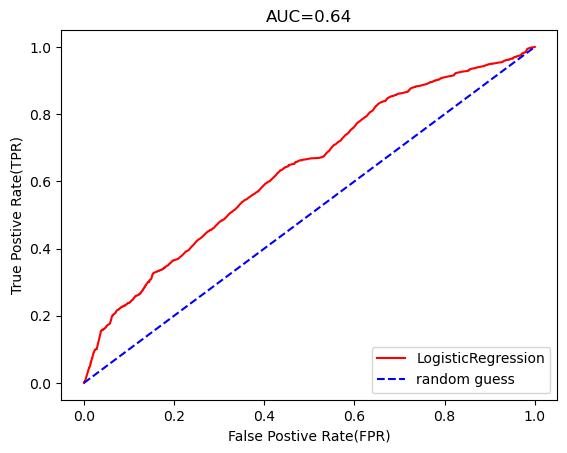

In [43]:
import matplotlib.pyplot as plt 

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, 'r-', label='LogisticRegression')
plt.plot([0, 1], [0, 1], 'b--', label='random guess')
plt.xlabel('False Postive Rate(FPR)')
plt.ylabel('True Postive Rate(TPR)')
plt.title("AUC={0:.2f}" .format(auc))
plt.legend(loc='lower right')